In [116]:
import madmom
from madmom.features.onsets import CNNOnsetProcessor, OnsetPeakPickingProcessor
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import butter, sosfilt
from scipy.misc import derivative
from matplotlib import collections
from modules.energy_based import legato_mg

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [66]:
AUDIO_PATH = 'datasets/initslurtest_vn/initslurtest_vn_wav/slurtest02.wav'
PASSAGES_PATH = 'datasets/initslurtest_vn/legato_parts/02.txt'


In [67]:
proc = CNNOnsetProcessor()
res = proc(AUDIO_PATH)

In [105]:
pp = OnsetPeakPickingProcessor()
onsets = pp.process_offline(res)
typ_dist = np.median(np.ediff1d(onsets))

pp = OnsetPeakPickingProcessor(combine=typ_dist*0.5)
mm_onsets = pp.process_offline(res)


102
0.2142857142857134
99


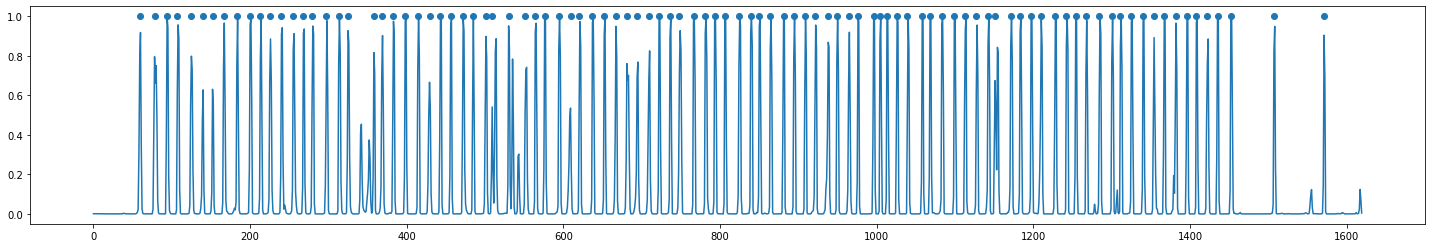

In [101]:
plt.figure(figsize=(25, 4))
plt.plot(res)
plt.scatter(mm_onsets*100, np.ones_like(mm_onsets))

In [93]:
FPS = 100
sig = madmom.audio.signal.Signal(AUDIO_PATH, dtype=float)
frames = madmom.audio.signal.FramedSignal(signal=sig, frame_size=1024, fps=FPS)


In [84]:
parts = np.loadtxt(PASSAGES_PATH, usecols=0)
n_parts = len(parts)-1

marg = 0.02

In [85]:
midi_file = madmom.io.midi.MIDIFile("datasets/initslurtest_vn/midi_generated/slurtest01.mid")
midi_onsets = midi_file.notes[:,0].reshape((-1))
midi_pitches = midi_file.notes[:,1].reshape((-1))
midi_durs = midi_file.notes[:,2].reshape((-1))

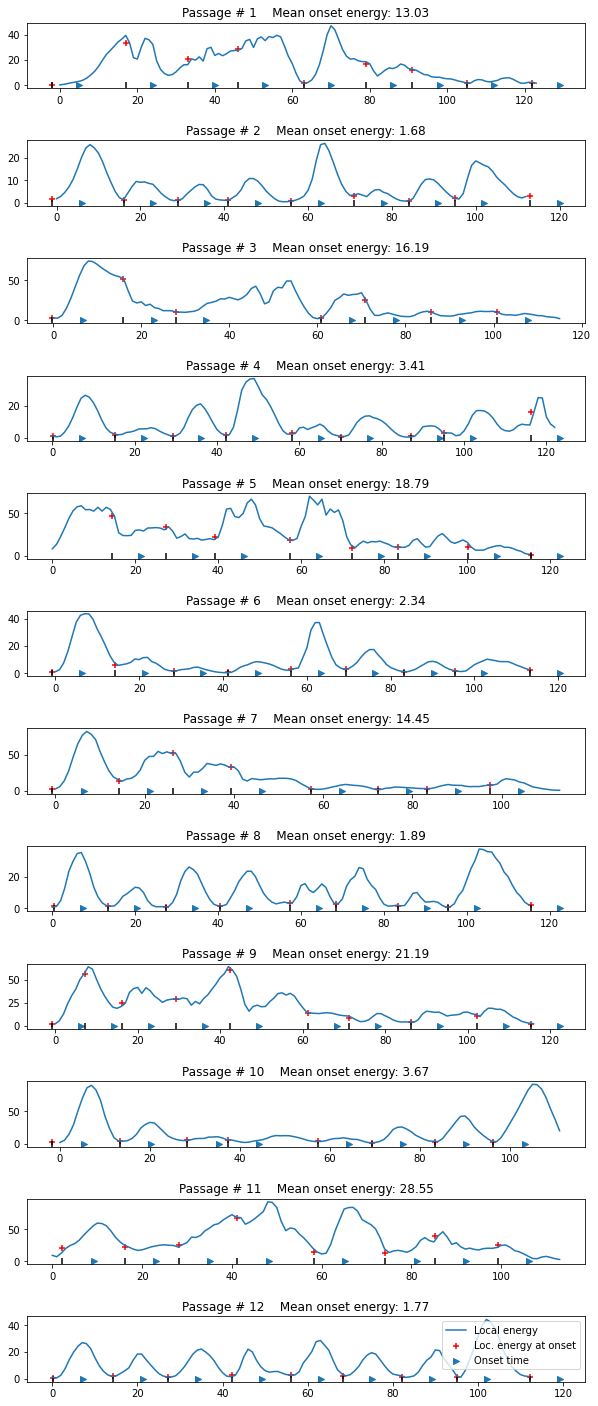

In [103]:
fig, axs = plt.subplots(n_parts, 1, figsize=(10,25))
onsets = mm_onsets
for i in range(n_parts):
    axs[i].plot(frames.energy()[int(parts[i]*FPS): int(parts[i+1]*FPS)])
    onset_idx = np.where((onsets>=parts[i]-marg) & (onsets<parts[i+1]))[0]
    onset_set = onsets[onset_idx]
    local_energy = frames.energy()[(onset_set*FPS).astype(int)]
    local_energy.shape
    onset_set_shifted = onset_set - parts[i]
    axs[i].scatter(onset_set_shifted*FPS, local_energy, marker='+', color="red")
    axs[i].scatter((onset_set_shifted+typ_dist*0.5)*FPS, np.zeros_like(onset_set), marker=">")
    axs[i].scatter(onset_set_shifted*FPS, np.zeros_like(onset_set), marker='|', color="black")
    axs[i].title.set_text("Passage # {}    Mean onset energy: {:.2f}".format(
        i+1, np.mean(local_energy)))
        
plt.legend(["Local energy", "Loc. energy at onset", "Onset time"], loc=1)
plt.subplots_adjust(wspace=0.4, hspace=0.8)
plt.show()

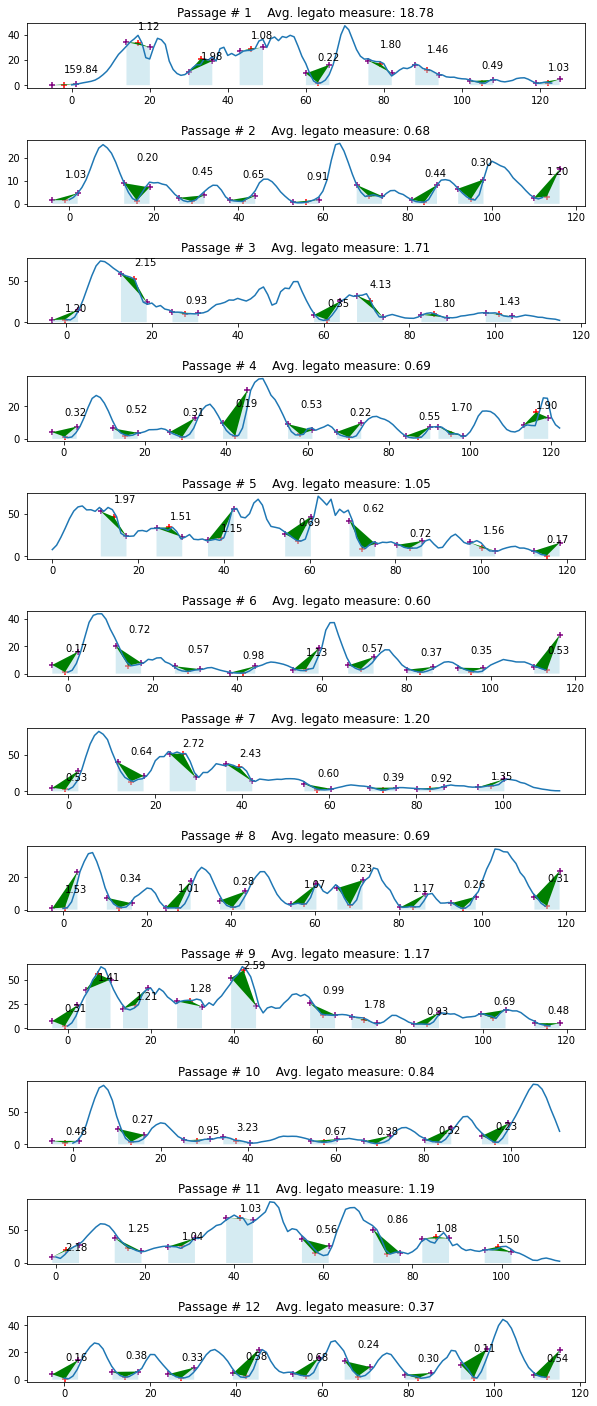

In [64]:
TRI_SIZE = 0.03 # seconds
energy = frames.energy()
fig, axs = plt.subplots(n_parts, 1, figsize=(10,25))
onsets = mm_onsets
for i in range(n_parts):
    # Plot energy envelope
    axs[i].plot(energy[int(parts[i]*FPS): int(parts[i+1]*FPS)])
    

    # Retrieve onsets
    onset_idx = np.where((onsets>=parts[i]-marg) & (onsets<parts[i+1]))[0]
    onset_set = onsets[onset_idx]
    onset_energy = energy[(onset_set*FPS).astype(int)]
    onset_set_shifted = onset_set - parts[i]
    

    # Plot onsets and energy at onsets
    axs[i].scatter(
        onset_set_shifted*FPS, 
        onset_energy, 
        marker='+', color="red"
    )
    axs[i].scatter(
        (onset_set_shifted+TRI_SIZE)*FPS, 
        energy[((onset_set+TRI_SIZE)*FPS).astype(int)], 
        marker='+', color="purple"
    )
    axs[i].scatter(
        (onset_set_shifted-TRI_SIZE)*FPS, 
        energy[((onset_set-TRI_SIZE)*FPS).astype(int)], 
        marker='+', color="purple"
    )
    area_1 = [
        [(start_x, start_y), (end_x, end_y), (mid_x, mid_y)]
        for (start_x,start_y, end_x, end_y, mid_x, mid_y)  in 
        zip(
            (onset_set_shifted-TRI_SIZE)*FPS,
            energy[((onset_set-TRI_SIZE)*FPS).astype(int)],
            (onset_set_shifted+TRI_SIZE)*FPS,
            energy[((onset_set+TRI_SIZE)*FPS).astype(int)],
            onset_set_shifted*FPS,
            energy[(onset_set*FPS).astype(int)]
        )
    ]
    pc1 = collections.PolyCollection(
        area_1, 
        facecolors = 'green'
    )
    area_2 = [
        [(start_x, start_y), (end_x, end_y), (end_x, 0), (start_x,0)]
        for (start_x,start_y, end_x, end_y, mid_x, mid_y)  in 
        zip(
            (onset_set_shifted-TRI_SIZE)*FPS,
            energy[((onset_set-TRI_SIZE)*FPS).astype(int)],
            (onset_set_shifted+TRI_SIZE)*FPS,
            energy[((onset_set+TRI_SIZE)*FPS).astype(int)],
            onset_set_shifted*FPS,
            energy[(onset_set*FPS).astype(int)]
        )
    ]
    pc2 = collections.PolyCollection(
        area_2, 
        facecolors = 'lightblue',
        alpha = 0.5
    )

    legato_meas = [
        e0/np.min((e1,e2))
        for (e0, e1, e2) in
        zip(
            energy[(onset_set*FPS).astype(int)],
            energy[((onset_set-TRI_SIZE)*FPS).astype(int)],
            energy[((onset_set+TRI_SIZE)*FPS).astype(int)]
        )
    ]

    axs[i].add_collection(pc2)
    axs[i].add_collection(pc1)
    for (x, y, s) in zip(
            onset_set_shifted*FPS,
            energy[((onset_set-TRI_SIZE)*FPS).astype(int)],
            legato_meas
    ):
        axs[i].text(x=x, y=y+10, s="{:.2f}".format(s))
    
    axs[i].title.set_text("Passage # {}    Avg. legato measure: {:.2f}".format(
        i+1, np.mean(legato_meas))   
    ) 
    #axs[i].scatter(onset_set_shifted*FPS, np.zeros_like(onset_set), marker='|', color="black")
    

plt.subplots_adjust(wspace=0.4, hspace=0.8)
plt.show()

In [117]:
TRI_SIZE = 0.03 # seconds

onsets, measures = legato_mg(AUDIO_PATH, sep=TRI_SIZE)


ValueError: too many values to unpack (expected 2)

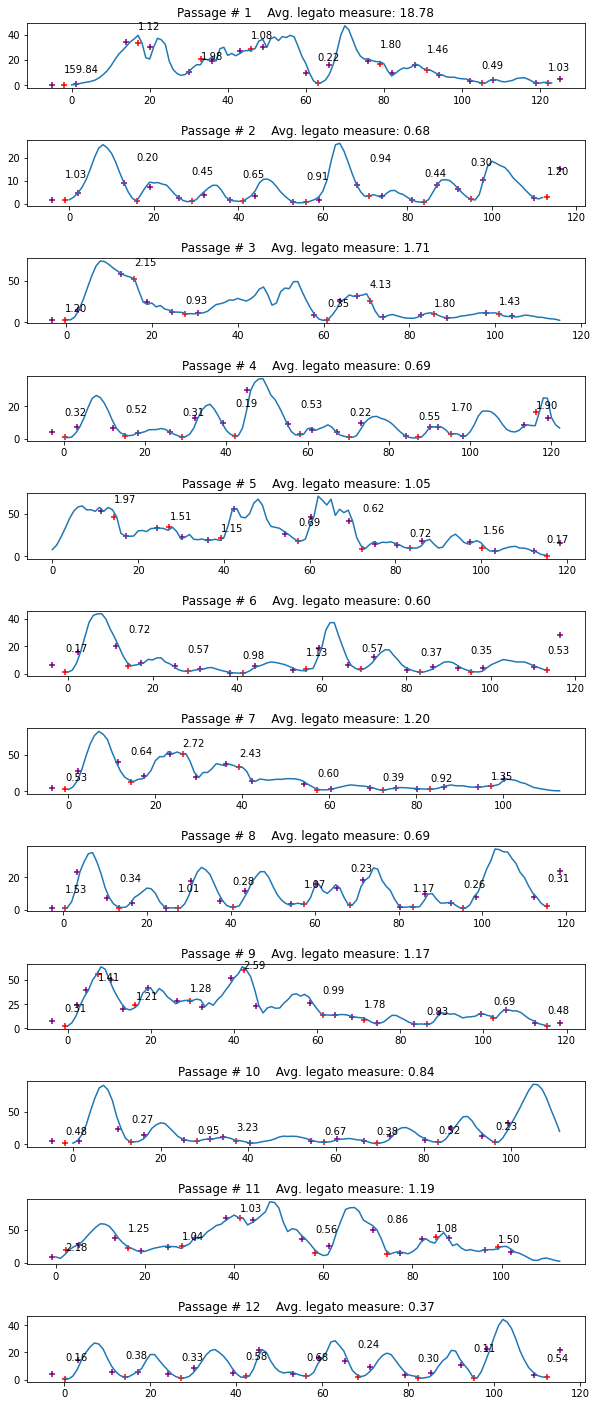

In [110]:
measures = leg[:,1].reshape((-1))
onsets = leg[:,0].reshape((-1))
fig, axs = plt.subplots(n_parts, 1, figsize=(10,25))
for i in range(n_parts):
    # Plot energy envelope
    axs[i].plot(energy[int(parts[i]*FPS): int(parts[i+1]*FPS)])
    
    # Retrieve onsets
    onset_idx = np.where((onsets>=parts[i]-marg) & (onsets<parts[i+1]))[0]
    onset_set = onsets[onset_idx]
    onset_energy = energy[(onset_set*FPS).astype(int)]
    onset_set_shifted = onset_set - parts[i]

    # Plot onsets and energy at onsets
    axs[i].scatter(
        onset_set_shifted*FPS, 
        onset_energy, 
        marker='+', color="red"
    )
    axs[i].scatter(
        (onset_set_shifted+TRI_SIZE)*FPS, 
        energy[((onset_set+TRI_SIZE)*FPS).astype(int)], 
        marker='+', color="purple"
    )
    axs[i].scatter(
        (onset_set_shifted-TRI_SIZE)*FPS, 
        energy[((onset_set-TRI_SIZE)*FPS).astype(int)], 
        marker='+', color="purple"
    )

    legato_meas = measures[onset_idx]

    for (x, y, s) in zip(
            onset_set_shifted*FPS,
            energy[((onset_set-TRI_SIZE)*FPS).astype(int)],
            legato_meas
    ):
        axs[i].text(x=x, y=y+10, s="{:.2f}".format(s))
    
    axs[i].title.set_text("Passage # {}    Avg. legato measure: {:.2f}".format(
        i+1, np.mean(legato_meas))   
    ) 
    #axs[i].scatter(onset_set_shifted*FPS, np.zeros_like(onset_set), marker='|', color="black")
    

plt.subplots_adjust(wspace=0.4, hspace=0.8)
plt.show()